 # Mask RCNN and Sobel Tranform Artwork!

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/coco/"))  # To find local version


# Import COCO config
from Mask_RCNN.samples.coco import coco

%matplotlib inline 

Using TensorFlow backend.


### Configure Mask RCNN for inference

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights(os.path.join(ROOT_DIR, "mask_rcnn_coco.h5"), by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Load your own clip, Visualize a frame

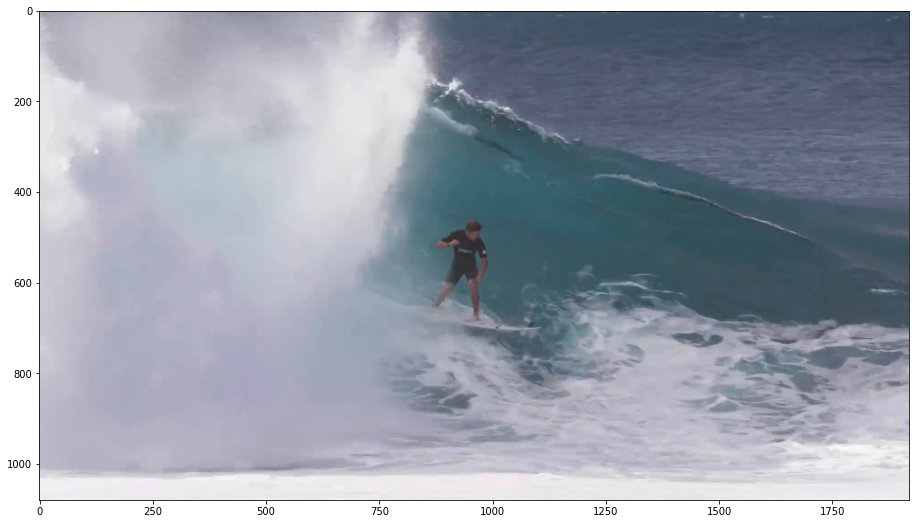

In [3]:
clip1 = VideoFileClip("vids/surfing.mp4") # replace with your file's name
testframe = clip1.get_frame(4) # change 4 to something within your file's duration (in seconds)
plt.figure(figsize=(30,9))
plt.imshow(testframe)

### Run Mask RCNN on above frame

Processing 1 images
image                    shape: (1080, 1920, 3)       min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


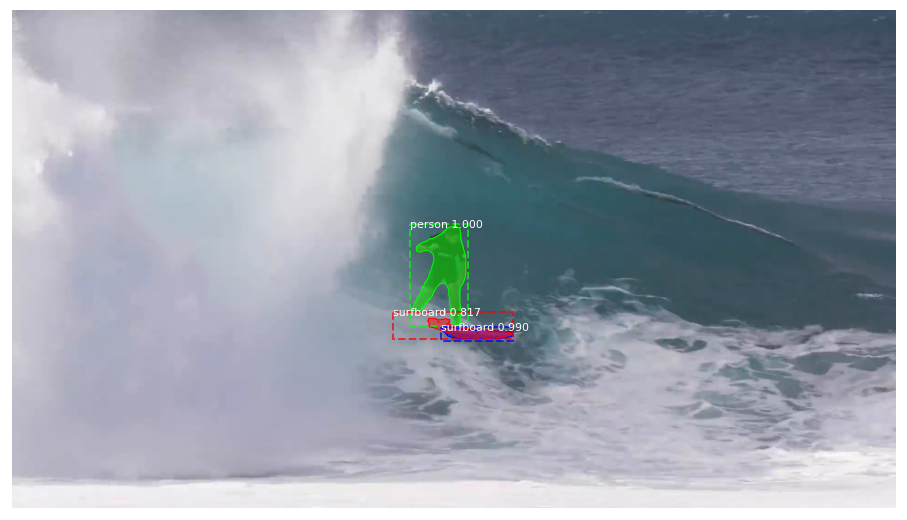

In [4]:
# Run detection
results = model.detect([testframe], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(testframe, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

### Main image processing pipeline!

Feel free to change to suit your artistic sensibilities :)

In [6]:
def process_image(image, mask_color, sobel_color, sobel_threshold=20, mask_area_threshold=20000, plot_frame=False):
    '''
    Main image processing pipeline. Takes in image and returns a beautiful result!
    
    arguments:
    image -- input RGB image (required)
    mask_color -- 3 element list denoting RGB color of mask (required)
    sobel_color -- 3 element list denoting RGB color of Sobel "lines" (required)
    sobel_threshold  -- filter out Sobel "lines" with magnitude less than this amount (optional, default 20)
    mask_area_threshold  -- filter out masks with less than this pixel amount in area (optional, default 20000)
    plot_frame -- boolean denoting whether to plot resulting image (optional, default False)
    
    returns:
    final_result -- RGB image of same size and shape as input
    '''
    # Run detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Get the indices of the mask(s) that correspond to people
    human_ind = class_names.index('person')
    human_mask_inds = np.where(r['class_ids'] == human_ind)[0]
    
    # OPTIONAL: uncomment below line to filter out smaller area masks. Useful if you have a frame 
    # with an audience in the background and only want to focus on people in foreground.
#     human_mask_inds = [ind for ind in human_mask_inds if np.sum(r['masks'][:,:,ind])>mask_area_threshold]

    final_mask =  np.any(r['masks'][:,:,human_mask_inds],axis=2)
    indsx, indsy = np.where(final_mask==True)
    
    # Create RCNN mask
    mask = np.zeros_like(image)
    mask[indsx, indsy, :] = mask_color

    # Compute Sobel transform
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    scaled_sobel = cv2.addWeighted(np.absolute(sobelx), 0.5, np.absolute(sobely), 0.5, 0)
    
    # Identify areas to apply Sobel "lines". Only apply in areas overlapping with RCNN mask
    sindsx, sindsy = np.where((scaled_sobel >= sobel_threshold) & (final_mask==True))
    
    # Choose your own adventure!
    # Option 1: Replace original pixels completely with new RCNN mask color 
    final_result = image.copy()
    final_result[indsx, indsy, :] = mask_color
    final_result[sindsx, sindsy, :] = sobel_color
    
    # Option 2: Use cv2.addWeighted for a cool "transparent effect" 
#   final_result = cv2.addWeighted(image, 1, mask, 1, 0)
#   final_result[sindsx, sindsy, :] = sobel_color

    # Option 3: get come up with something else

    if plot_frame:
        plt.figure(figsize=(30,9))
        plt.imshow(final_result)
    return final_result

In [ ]:
 _ = process_image(testframe, mask_color=[255, 165, 0], sobel_color=[165,0,255], plot_frame=True)

In [ ]:
output = 'outputvid.mp4'

output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))